In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

import sklearn.metrics # mse error

# autoregressive process

we will forecast weekly foot traffic in store

In [2]:
df = pd.read_csv('foot_traffic.csv')

In [3]:
df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


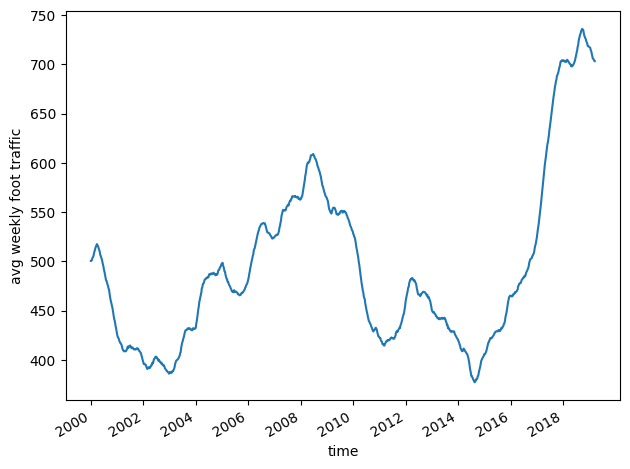

In [4]:
fig, ax = plt.subplots()

ax.plot(df.foot_traffic)

ax.set_xlabel('time')
ax.set_ylabel('avg weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

# tilt the labels on the x-axis ticks so that they display nicely.
fig.autofmt_xdate()

plt.tight_layout()

We can see that the data has trends, so probably no stationary, it does not seem to have any seasonality either. Let's check for stationarity with out reliable adf test.

In [5]:
adf = sm.tsa.stattools.adfuller(df.foot_traffic)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -1.1758885999240756
p-value 0.6838808917896185


p value larger than 0.05 so we cannot reject the null hypothesis and the series is not stationary. To check if it's a random walk we will have to transfrom it, let's get the difference

In [6]:
foot_traffic_diff = np.diff(df.foot_traffic, n = 1)

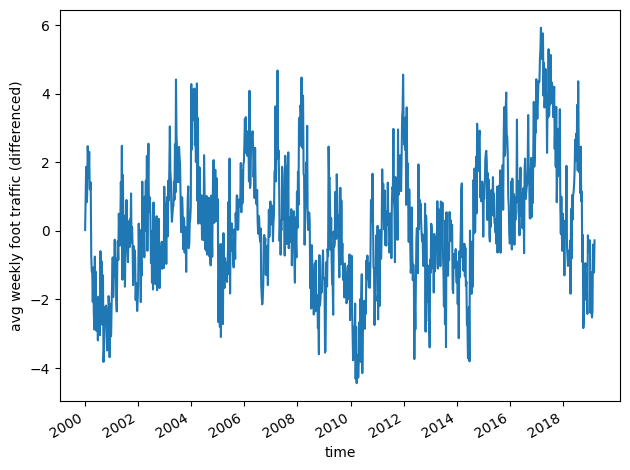

In [7]:
fig, ax = plt.subplots()

ax.plot(foot_traffic_diff)

ax.set_xlabel('time')
ax.set_ylabel('avg weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

# tilt the labels on the x-axis ticks so that they display nicely.
fig.autofmt_xdate()

plt.tight_layout()

Let's run the test again

In [8]:
adf = sm.tsa.stattools.adfuller(foot_traffic_diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -5.268231347422038
p-value 6.3693176547814515e-06


p value less than 0.05 and adf statistic is a negative number so we can reject the null hypothesis, meaning we have an stationary series now. Next step let's do the ACF plot to check for correlations

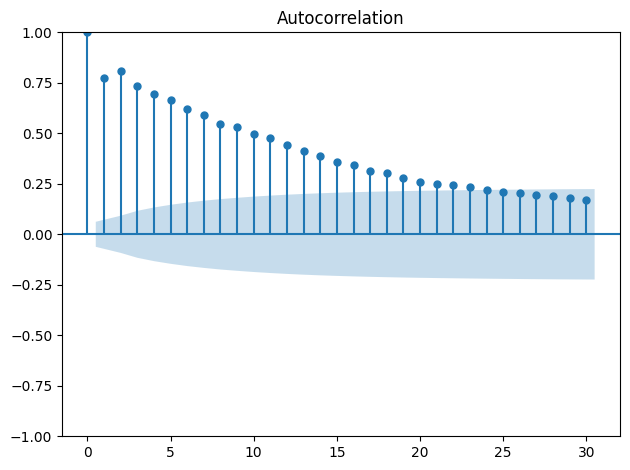

In [9]:
sm.graphics.tsa.plot_acf(foot_traffic_diff, lags = 30)
plt.tight_layout()

we can see that we have a significant correlation beyond lag 0, so the process is not a random walk. We can see how the correlations slowly decreases, there is no lag where it abruptly becomes non-significant therefore we cannot use $MA(q)$

## the partial autocorrelation function

Let's forget about our foot traffic problem for a moment, and let’s consider the following scenario. Suppose we have the following $AR(2)$ process:

$\displaystyle y_t=0.33y_{t-1}+0.50y_{t-2}$

We know this is a second order autoregression, because we defined it, let's plot the partial autocorrelation of it to see how it looks

In [10]:
np.random.seed(42)

In [11]:
ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.5])

In [12]:
# simulate the AR(2) process and generate 1,000 samples.
ar2_process = sm.tsa.ArmaProcess(ar2, ma2).generate_sample(nsample = 1000)

/Users/bsantanad/development/n/time-series/venv/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


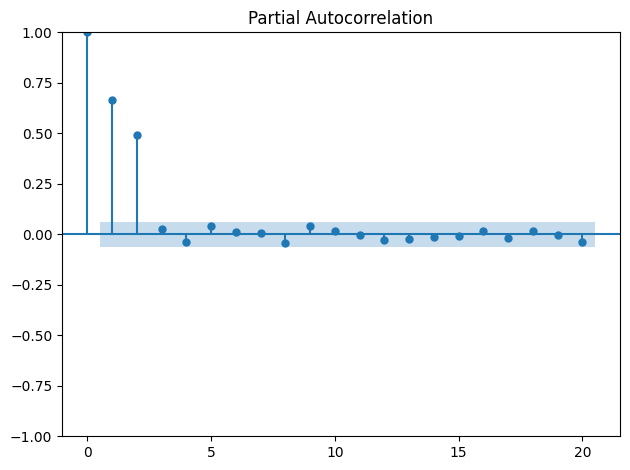

In [13]:
sm.graphics.tsa.plot_pacf(ar2_process, lags = 20)
plt.tight_layout()

We can see that after lag 2 the partial autocorrealtion coefficients are not significantly different from 0. And since we created a process with $AR(2)$ in the first place, we now know how a PACF plot for it looks 

### continue with foot traffic

after that small break, we can do the PACF plot for our foot traffic data

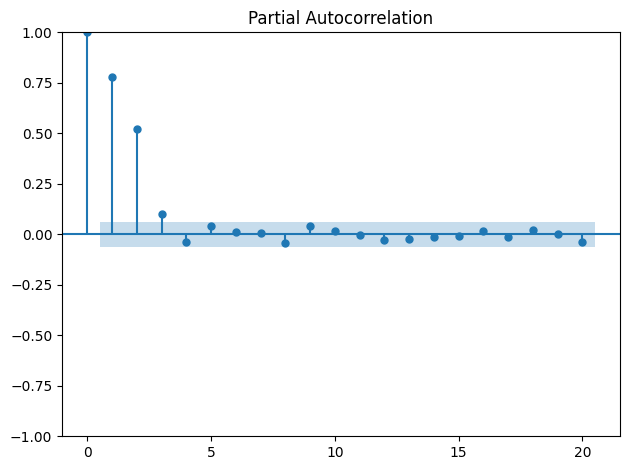

In [14]:
sm.graphics.tsa.plot_pacf(foot_traffic_diff, lags = 20)
plt.tight_layout()

We can see that we have no significant coeficients after lag 3, therefore in $AR(p)$ we will have $p=3$, meaning it is an autoregressive process of order 3

## forecasting

Now that we now that we have an $AR(3)$ we will forecast the foot traffic of the store, we will split, the last 52 week will be our testing set and the rest our training

In [15]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})

In [16]:
train = df_diff[:-52]
test = df_diff[-52:]

In [17]:
print(len(train))
print(len(test))

947
52


Let's visualize the training period in both diff and normal dataset

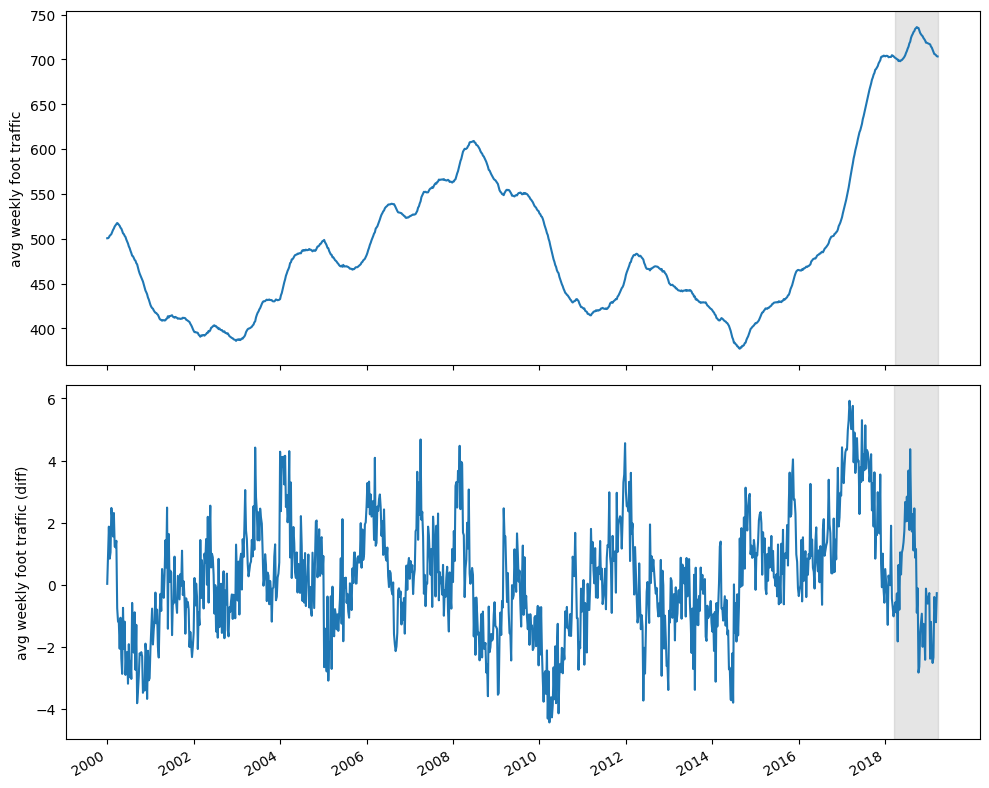

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (10, 8))

ax1.plot(df.foot_traffic)
ax1.set_ylabel('avg weekly foot traffic')
ax1.axvspan(948, 1000, color = '#808080', alpha = 0.2)

ax2.plot(df_diff.foot_traffic_diff)
ax2.set_ylabel('avg weekly foot traffic (diff)')
# we only go to 999 since we lost a value when diferencing
ax2.axvspan(947, 999, color = '#808080', alpha = 0.2)


plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

Now we will define our rolling forecast function to compare the $AR(3)$ against the baseline forecasts

In [19]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,
                     window: int, method: str) -> list:
    '''
    given a dataset, forecast using one of three methods:

        1. historical mean (mean)
        2. last value  (last)
        3. autoregressive (ar)
    
    the training length will be updated with each iteration as if we were
    seeing new observations

    :param pd.DataFrame df: data frame with two columns
    :param int train_len: number of data point that can be used to fit the
                          model
    :param int horizon: length of the test set, how many values we want to
                        predict
    :param int window: how many timesteps are predicted at a time
    :param int method: mean | last | AR, method used to do the forecast

    :return:
    :rtype: list
    '''

    # train length + the horizon make the total length of the dataset
    # meaning it includes the prediction as well
    total_len = train_len + horizon

    if method.lower() == 'mean':
        pred_mean = []

        # go from last train value to total length, step by step
        for i in range(train_len, total_len, window):
            # this means calculating the mean thru each timestep
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range (window))

        return pred_mean

    if method.lower() == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    if method.lower() == 'ar':
        pred_ma = []

        for i in range (train_len, total_len, window):
            # the order specifies an AR(3) model.
            model = sm.tsa.statespace.SARIMAX(df[:i], order = (3, 0, 0))
            r = model.fit(disp = False)
            predictions = r.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ma.extend(oos_pred)

        return pred_ma

    return []

In [20]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

/var/folders/5r/60f9npy54bz3_gzp5pkztxzw0000gn/T/ipykernel_11068/3571729920.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = pred_mean
/var/folders/5r/60f9npy54bz3_gzp5pkztxzw0000gn/T/ipykernel_11068/3571729920.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_last_value'] = pred_last_value
/var/folders/5r/60f9npy54bz3_gzp5pkztxzw0000gn/T/ipykernel_11068/3571729920.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [21]:
test.head()

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


Now that we have the forecasts, let's plot them

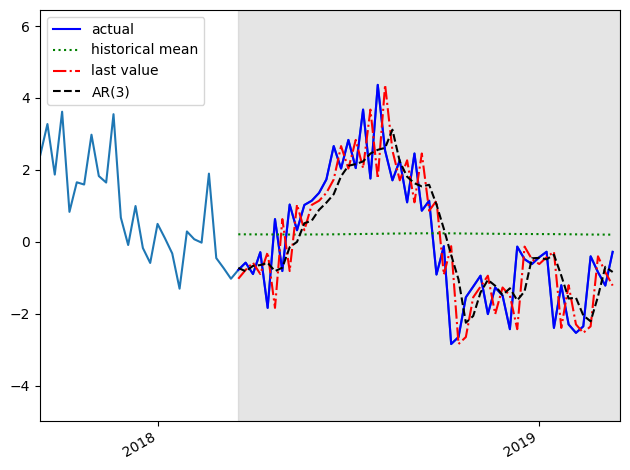

In [22]:
fig, ax = plt.subplots()

plt.plot(df_diff.foot_traffic_diff)
plt.plot(test.foot_traffic_diff, 'b-', label = 'actual')
plt.plot(test.pred_mean, 'g:', label = 'historical mean')
plt.plot(test.pred_last_value, 'r-.', label = 'last value')
plt.plot(test.pred_AR, 'k--', label = 'AR(3)')

ax.legend(loc = 2)

plt.axvspan(947, 999, color = '#808080', alpha = 0.2)
plt.xticks([936, 988],[2018, 2019])

ax.set_xlim(920, 999)

fig.autofmt_xdate()
plt.tight_layout()

In [23]:
mse_mean = sklearn.metrics.mean_squared_error(test.foot_traffic_diff, test.pred_mean)
mse_last = sklearn.metrics.mean_squared_error(test.foot_traffic_diff, test.pred_last_value)
mse_ma = sklearn.metrics.mean_squared_error(test.foot_traffic_diff, test.pred_AR)

print(f'MSE:\nmean {mse_mean}\nlast value {mse_last}\nautoregressive process(3) {mse_ma}')

MSE:
mean 3.1079979374701447
last value 1.448730118495964
autoregressive process(3) 0.9242479161081346


## transform back our dataset

Now that we have our champion model (moving average of order 2) we need to transform back our dataset

In [24]:
df['pred_foot_traffic'] = pd.Series()
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test.pred_AR.cumsum()

/var/folders/5r/60f9npy54bz3_gzp5pkztxzw0000gn/T/ipykernel_11068/421915572.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['pred_foot_traffic'] = pd.Series()


In [25]:
df.tail()

,foot_traffic,pred_foot_traffic
995,706.009031,707.386725
996,705.610549,705.182354
997,704.771335,703.667661
998,703.559920,702.977531
999,703.285236,702.143383


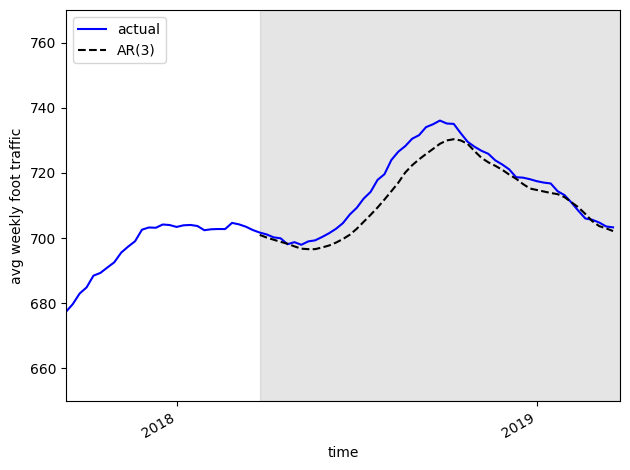

In [26]:
fig, ax = plt.subplots()

ax.plot(df.foot_traffic, 'b-', label = 'actual')
ax.plot(df.pred_foot_traffic, 'k--', label = 'AR(3)')

ax.set_xlabel('time')
ax.set_ylabel('avg weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.legend(loc = 2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [27]:
mae = sklearn.metrics.mean_absolute_error(df['foot_traffic'].iloc[948:], df['pred_foot_traffic'].iloc[948:])
print(mae)

3.4780335603473724


This means that our predictions are off by 3 and a half people on average